## **Setup**

In [ ]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q accelerate -U
!pip install -q trl
# !pip install -q numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00


In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

import os
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
import peft
from itertools import chain
from collections import Counter
import collections
import math
import numpy as np
from scipy.special import softmax
import pandas as pd

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## **LoRA Setup**

In [ ]:
# We freeze the models weights by setting the requires_grad attribute to False.

for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [ ]:
# Prints the number of trainable parameters in the model.

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
# Setup LoRA Config using peft

from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=64,
    lora_alpha=128,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 2359296 || all params: 126799104 || trainable%: 1.8606566809809635


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


## **Data Loading and Tokenization**

In [ ]:
data = []
prompts = []
responses = []
only_sherlock_data = []
response_lines = []
with open("context_data_all.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            # concatenated_lines = f"{lines[i].strip()} ->: {lines[i+1].strip()}"
            # data.append(concatenated_lines)
            promptLine = "Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \"" +  f"{lines[i].strip()}" + "\""
            responseLine = f"{lines[i+1].strip()}"
            prompts.append(promptLine)
            response_lines.append(responseLine)
            responses.append("Sherlock: " + responseLine)
            only_sherlock_data.append(responseLine)
            # data.append({"Prompt": promptLine, "Response": responseLine})
            data.append("Prompt: \n" + promptLine + "\n### Response: \n" + responseLine)

In [ ]:
def prompt_formatter(data):
    output_texts = []
    text = f"{data['Prompt']} \n{data['Response']}"
    output_texts.append(text)
    return output_texts

In [ ]:
len(data)

1443

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

In [ ]:
from datasets import Dataset
train_ds = Dataset.from_dict({"text" : train_data})
val_ds = Dataset.from_dict({"text" : val_data})
print(train_ds)

Dataset({
    features: ['text'],
    num_rows: 1154
})


## **Frequency Extraction**

### Colloquial English Frequency Extraction

In [ ]:
# Computing "typical" English token usage

english_words_df = pd.read_csv('unigram_freq.csv')

total_english_tokens = 0
english_token_frequencies = collections.defaultdict(int)

for _, row in english_words_df.iterrows():
  word = row["word"]
  freq = row["count"]
  takens = []
  try:
    tokens = tokenizer(word)["input_ids"]
    for token in tokens:
      english_token_frequencies[token] += freq
      total_english_tokens += freq
  except:
    print(f"Was unable to tokenize this word: {word}")

Was unable to tokenize this word: nan
Was unable to tokenize this word: nan


In [ ]:
for token in sorted(english_token_frequencies.keys(), key=lambda x: english_token_frequencies[x], reverse=True)[:10]:
    print(f"{token}: {english_token_frequencies[token]}. Corresponding word: {tokenizer.decode(token)}")

1169: 23417337725. Corresponding word: the
392: 13310531902. Corresponding word: and
1659: 13250973197. Corresponding word: of
1462: 12282037502. Corresponding word: to
64: 10455986235. Corresponding word: a
259: 10071072183. Corresponding word: in
82: 8804813095. Corresponding word: s
1640: 6079882982. Corresponding word: for
271: 5688234995. Corresponding word: is
66: 4564177047. Corresponding word: c


### Sherlock Frequency Extraction

In [ ]:
# Splitting data into training and testing data

train_data_only_sherlock_freq, val_data_only_sherlock_freq = train_test_split(only_sherlock_data, test_size=0.2, random_state=50)

train_data_only_sherlock_freq = [tokenizer(line) for line in train_data_only_sherlock_freq]
val_data_only_sherlock_freq = [tokenizer(line) for line in val_data_only_sherlock_freq]

In [ ]:
sherlock_freq = [tokenizer(line) for line in response_lines]

In [ ]:
# Computing number of tokens in training data

total_num_tokens = 0

for i in range(len(sherlock_freq)):
  total_num_tokens += len(sherlock_freq[i]['input_ids'])

In [ ]:
input_ids = [d['input_ids'] for d in sherlock_freq]
flattened_tokens = list(chain.from_iterable(input_ids))

sherlock_token_frequencies = Counter(flattened_tokens)

In [ ]:
for token in sorted(sherlock_token_frequencies.keys(), key=lambda x: sherlock_token_frequencies[x], reverse=True)[:10]:
    print(f"{token}: {sherlock_token_frequencies[token]}. Corresponding word: {tokenizer.decode(token)}")

13: 2784. Corresponding word: .
11: 2415. Corresponding word: ,
262: 1751. Corresponding word:  the
286: 1080. Corresponding word:  of
257: 1026. Corresponding word:  a
318: 638. Corresponding word:  is
284: 625. Corresponding word:  to
290: 610. Corresponding word:  and
314: 502. Corresponding word:  I
345: 403. Corresponding word:  you


### Multiplication Factor

In [ ]:
multiplication_factor = {}
for i in range(50257):
  if ((i not in sherlock_token_frequencies) or
      (sherlock_token_frequencies == 0) or
      (english_token_frequencies[i] == 0)):
      multiplication_factor[i] = 1
  else:
    sherlock_prob = sherlock_token_frequencies[i] / total_num_tokens
    english_prob = english_token_frequencies[i] / total_english_tokens
    multiplication_factor[i] = (sherlock_prob / english_prob)

In [ ]:
for idx in sorted(multiplication_factor.keys(), key=lambda x: multiplication_factor[x], reverse=True)[:10]:
    print(tokenizer.decode(idx), multiplication_factor[idx], sherlock_token_frequencies[idx] / total_num_tokens, english_token_frequencies[idx] / total_english_tokens)

erning 19697.12577175326 0.0005293572720455247 2.687484855301333e-08
ablish 3318.4654289421824 6.616965900569059e-05 1.993983677774317e-08
cknowled 1035.1397420711921 4.4113106003793724e-05 4.2615604648246446e-08
undrum 684.4137643089966 0.0004190745070360404 6.123116291489985e-07
entle 176.15514722633262 2.2056553001896862e-05 1.2521094812834245e-07
eking 125.2666963731066 8.822621200758745e-05 7.043070070659951e-07
ossibly 123.94192617691084 4.4113106003793724e-05 3.559175443249773e-07
itivity 103.20308238343394 6.616965900569059e-05 6.411597161395644e-07
itates 89.8150340053184 0.00011028276500948432 1.2278875828622848e-06
vable 87.84783556137303 6.616965900569059e-05 7.532303850498691e-07


## **Loss Function**

In [ ]:
class CustomStyleTransferLoss(nn.Module):
    def __init__(self, epsilon, beta, multiplication_factor):
        super(CustomStyleTransferLoss, self).__init__()
        self.epsilon = epsilon
        self.beta = beta
        self.multiplication_factor = multiplication_factor

        self.log_factors = []
        for index in range(len(multiplication_factor)):
            self.log_factors.append(math.log(multiplication_factor[index], beta))
        self.log_factors = torch.tensor(self.log_factors)
        print(len(multiplication_factor))
        print(len(self.log_factors))

    def forward(self, logits, labels):
        # Converting logits to probabilities
        prob = torch.softmax(logits, dim=2)

        # Ensuring same device
        device = prob.device
        self.log_factors = self.log_factors.to(device)

        # finding indexes to ignore in the final loss calculation
        target_mask = (labels != -100)

        # replacing -100 labels with 50256 temporary placeholder
        labels = torch.where(labels == -100, 50256, labels)

        # We want to convert each label to a probability function for comparison
        smooth_labels = torch.zeros_like(prob, dtype=torch.float, device=device)

        smooth_labels.add_(self.log_factors)

        softmax = nn.Softmax(dim=2)

        # Setting probability of non-ground-truth labels with soft-maxing
        # Note: Setting the ground-truth lable to -inf in order to ignore it during the soft-max for non-ground truth values
        smooth_labels.scatter_(2, labels.unsqueeze(2), -np.inf)
        smooth_labels = softmax(smooth_labels) * epsilon

        # Giving the ground-truth labels their probability
        smooth_labels.scatter_(2, labels.unsqueeze(2), 1 - epsilon)

        # Calculate the cross-entropy loss
        loss = -torch.sum(smooth_labels * torch.log(prob + 1e-10), dim=2)

        mean_loss = loss[target_mask].mean()
        return mean_loss

beta = 4
epsilon = 0.1

# Initialize the custom loss function
custom_loss_fn = CustomStyleTransferLoss(epsilon, beta, multiplication_factor)

50257
50257


In [ ]:
from torch import nn
from transformers import Trainer

class CustomTrainer(SFTTrainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        logits = logits[..., :-1, :].contiguous()
        labels = labels[..., 1:].contiguous()

        # Your custom loss function goes here
        custom_loss = custom_loss_fn(logits, labels)

        if return_outputs:
            return custom_loss, outputs
        else:
            return custom_loss

## **Training**

In [ ]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

trainer = CustomTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    dataset_text_field="text",
    max_seq_length=512,
    packing=False,
    formatting_func=prompt_formatter,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1000,
        learning_rate=2e-3,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    # data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
    data_collator = DataCollatorForCompletionOnlyLM("Prompt: ", tokenizer=tokenizer)
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.684200,4.476200
40,3.725600,3.717906
60,3.670500,3.583585
80,3.527900,3.485624
100,3.627400,3.417875
120,3.267700,3.384084
140,3.154400,3.347044
160,3.458600,3.314014
180,3.339700,3.304764
200,3.154700,3.282161


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

In [ ]:
test_trainer = SFTTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    dataset_text_field="text",
    max_seq_length=512,
    packing=False,
    formatting_func=prompt_formatter,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1530,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    # data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
    data_collator = DataCollatorForCompletionOnlyLM("Prompt: ", tokenizer=tokenizer)
)

results = test_trainer.evaluate()
print(f"Validation Loss: {results}")

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

Validation Loss: {'eval_loss': 1.901169776916504, 'eval_runtime': 2.031, 'eval_samples_per_second': 142.298, 'eval_steps_per_second': 18.218}


## **Sampling**

In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house? Or is it a muggled incident or a spontaneous event?"
### Response: 
He's not an elaborate subject. We've interviewed the police, but we've found nothing to support this hypothesis. We've shot an empty chamber and a bloodstained finger. And, while we're away, he should watch those who surround him. Perhaps he wants to eat. Or perhaps he's nervous or thirsty. Let's examine the house further. Iferning yourself, Mr. Robinson, the murderer


In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "A valuable artifact has been stolen from a museum, and there are no signs of forced entry. How would you deduce the method used by the thief to enter and exit undetected?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=125,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
A valuable artifact has been stolen from a museum, and there are no signs of forced entry. How would you deduce the method used by the thief to enter and exit undetected? The thief might have crafted a clever puzzle, or perhaps he was simply a skilled craftsman. The museum clerk should discreetly note the whereabouts of the thieves, or else the theft is simply a ploy to conceal a clandestine art trade. Whaterning experts would discern from the cryptic message on the exhibit floor, or from the minimalist sidewalks of a city?"
### Response: The solution to this perplexing puzzle appears to be a simple ploy. In attempting to decipher the cryptic messages in the museums, we should focus on the curators, for within the artifacts and halls lies the el

In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "A wealthy businessman is found dead with no apparent cause of death. The room's windows are sealed shut, and there's no sign of poison or violence. Shelock, how would you go about solving this death?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
A wealthy businessman is found dead with no apparent cause of death. The room's windows are sealed shut, and there's no sign of poison or violence. Shelock, how would you go about solving this death? Any hint that the businessman was attempting to hide or disguise an crime? Would you seek to break out the door or try to talk us into a stalling manner or catch us from continuing our enquiries? Would you let us enter the quiet during the daytime? Wouldn't we be tempted to wander away unnoticed or linger near the death of a loved one? Is there any hidden purpose or ritual that serves as a motive? Could the missing individual pose a larger threat than the forensic investigators suspected?
###


## **Graphs and Visualizations**

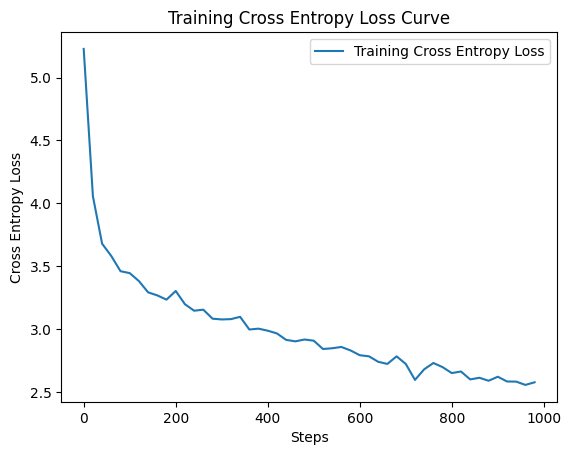

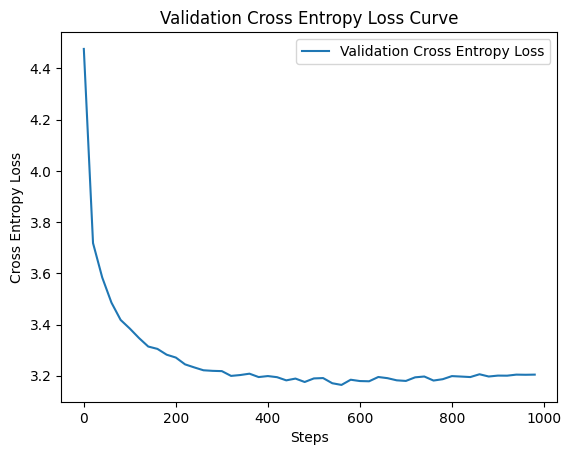

In [ ]:
import matplotlib.pyplot as plt

train_loss_values = []
val_loss_values = []

# Access the training and val loss values from the Trainer's log
for i, x in enumerate(trainer.state.log_history[:-1]):
  if (i+1) % 21 == 0:
    val_loss_values.append(x["eval_loss"])
  else:
    train_loss_values.append(x["loss"])
train_loss_values = [sum(train_loss_values[i:i+20]) / 20 for i in range(0, len(train_loss_values), 20)]

# Plot the training loss curve
plt.plot(train_loss_values, label="Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Training Cross Entropy Loss Curve")
plt.legend()
plt.show()

# Plot the val loss curve
plt.plot(val_loss_values, label="Validation Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Validation Cross Entropy Loss Curve")
plt.legend()
plt.show()

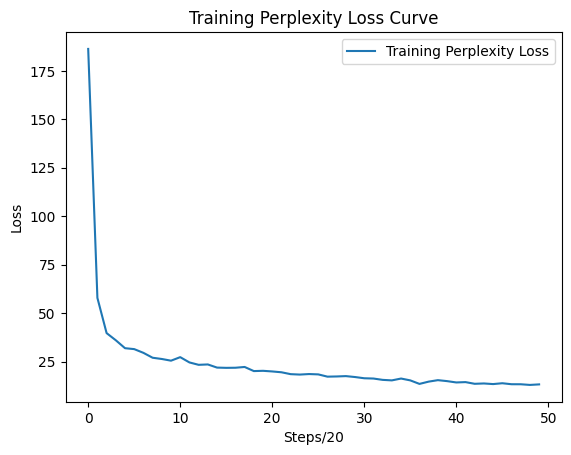

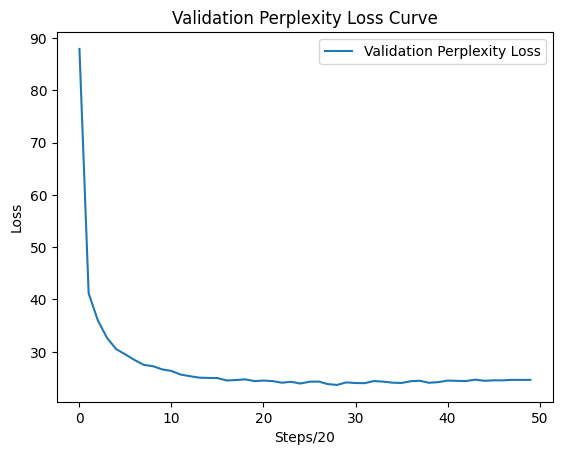

In [ ]:
import numpy as np
perplexity_train_loss_values = [np.exp(x) for x in train_loss_values]
perplexity_val_loss_values = [np.exp(x) for x in val_loss_values]

# Plot the training loss curve
plt.plot(perplexity_train_loss_values, label="Training Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Training Perplexity Loss Curve")
plt.legend()
plt.show()

# Plot the validation loss curve
plt.plot(perplexity_val_loss_values, label="Validation Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Validation Perplexity Loss Curve")
plt.legend()
plt.show()

## **Checkpointed Sampling**

In [ ]:
model_250 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-250")

set_seed(40)

device = model_250.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model_250.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? ->: 
Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. "Should I investigate business decision making to prevent financial ruin or accept decisionmaking as a valuable asset?"
### Response: 
Investigating the path to financial ruin is not a intellectual feat. Focus solely on the fundamentals of personal financial decisions. Avoid uncertainty, focus on individual goals, and avoid interpersonal conflicts. In the case of financial losses, "Eliminate all other factors, and the one which remains must be the truth." The realisation, after all, must be the truth. The path towards financial justice will not involve allay the suspicion or irretriven sympathies common among those who fear the ultimate outcome of their financial decisions. To avoid such personal confl

In [ ]:
model_500 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-500")

set_seed(40)

device = model_500.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model_500.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? ->: 
Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. "Should I investigate options for housing recovery?"
### Response: 
 Investigating options for housing recovery requires no detective work. Assess the options, explore alternatives; elementary principles of financial planning. "You see, but you do not observe."
### Response: 
Assess alternatives, my dear inquirer. Acknowledging reality requires a methodical inquiry. A simple calculation could lead to the deaths of millions of homes. An example, my dear query. "You see, but you cannot observe."
### Response: 
Conducting housing recovery requires a methodical appraisal. Assess alternatives, my dear sir. "If you see, I will, but you cannot observe." Here we are. "The world is full of obvious things which 

In [ ]:
model_750 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-750")

set_seed(40)

device = model_750.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model_750.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? ->: 
Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. "Should I engage in daily exercise for cardiovascular function?"
### Response: 
Engaging in exercise is no intellectual conundrum. Exercise, if exercised wisely, can mitigate the risk of cardiovascular decline. An exercise-filled home, my cardiovascular enquiry. "The proverbial rat dies," i.e. "The equation is the root of anyigga." The solution lies in the gradual march of these physiological inhibites into the human mind. Exercise, in those with an inclination towards fitness, has its roots in elementary principles of physiological effectiveness. Manifest destiny as an inevitable consequence. The simple truth behind your actions is more than the apparent illusory. My focus lies in the molecular aspect

In [ ]:
from transformers import set_seed

set_seed(40)

model_0 = GPT2LMHeadModel.from_pretrained("gpt2")

device = model_0.device
prompt = "There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model_0.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))